<a href="https://colab.research.google.com/github/ElizabethGhi/tools-for-remote-sensing-data-analysis/blob/main/Precipitacion_Mensual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install PyCRS

  Preparing metadata (setup.py) ... done
  Created wheel for PyCRS: filename=PyCRS-1.0.2-py3-none-any.whl size=32687 sha256=f410864b95098bf6debedd7b1d2244bb09ddc117350ff51c949afd996ddfeaa0
  Stored in directory: /root/.cache/pip/wheels/47/1d/70/7a5bdf33347e7c75e95b06b1fa38f076a59a9506653cc24aff
Successfully built PyCRS


SECCION GENERAL

In [2]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import datetime
import geemap
import os

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
# Trigger the authentication flow.
ee.Authenticate()
ee.Initialize(project='ee-elizabethguzmanhi') #Ingresar credenciales de cuenta en Earth Engine
geemap.ee_initialize()

In [4]:
#Función para añadir una capa de imagen de Earth Engine a un mapa de folium
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict["tile_fetcher"].url_format,
        attr="Map Data &copy; <a href='https://earthengine.google.com/'>Google Earth Engine</a>",
        name=name,
        overlay=True,
        control=True,
    ).add_to(self)
folium.Map.add_ee_layer = add_ee_layer

VISUALIZACION DE LA ZONA DE ESTUDIO (DEM Y POLÍGONOS)


In [7]:
# IMPORTAR SHAPES DEL AREA DE ESTUDIO
path = "/gdrive/My Drive/GitHub/RemoteSensing_DataAnalysis/SHP_CM"
Poligonos = os.path.join(path, "Poligonos.shp")
Basin_Mexico = os.path.join(path, "Basin_of_Mexico.shp")

Poligono_ee = geemap.shp_to_ee(Poligonos)   #Convertir poligonos a objeto ee
gdf = gpd.read_file(Poligonos)              #Convertir poligonos a df
Capa_CM = geemap.shp_to_ee(Basin_Mexico)    #Convertir capa de Cuenca de México a objeto ee

In [8]:
#IMPORTAR DATASETS DESDE EE (Uso de Suelo, Cuencas hidrológicas, DEM)
landcover = (ee.ImageCollection('MODIS/061/MCD12Q1').select('LC_Type1').filterDate("2022-01-01", "2022-12-31").first())
urban_area_mask = landcover.eq(13) # Filtrar uso de suelo urbano
BasinAtlas = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_10")
desired_feature = BasinAtlas.filter(ee.Filter.eq('HYBAS_ID', 7100839310)) #Filtrar una subcuenca hidrológica
srtm = ee.Image("CGIAR/SRTM90_V4")

In [9]:
# PARÁMETROS DE VISUALIZACIÓN
vis_params_srtm = {
    'min': 0,
    'max': 4000,
    'palette': ['blue', 'green', 'red']
}
vis_params_urban = {
    'min': 0,
    'max': 1,
    'palette': ['gray']
}
visParams_PREC = {
    'min': 0,
    'max': 800,
    'palette': ['001137', '0aab1e', 'e7eb05', 'ff4a2d', 'e90000']
}
# Estilo de rellenos transparentes
estilo_contornos = {
    'color': 'black',
    'fillColor': '00000000',
    'width': 2
}
# Aplicar estilos a polígonos
poligonos_contornos = Poligono_ee.style(**estilo_contornos)
subcuenca_hidrologica = desired_feature.style(**estilo_contornos)

In [10]:
map = geemap.Map(center=[19.5, -99], zoom=9)
# Agregar capas al mapa
map.add_ee_layer(srtm.select('elevation'), vis_params_srtm, 'Elevación')
map.add_ee_layer(landcover.updateMask(urban_area_mask), vis_params_urban, 'Urban Areas')

# Agregar poligonos al mapa
map.add_ee_layer(poligonos_contornos, {}, 'Polígonos')
map.add_ee_layer(subcuenca_hidrologica, {}, 'Subcuenca Hidrológica')

# Mostrar el mapa
map

Map(center=[19.5, -99], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

ANALISIS DE DATOS DE PRECIPITACION

In [11]:
#Definir periodo de análisis y descarga del dataset
i = "2000-01-01"
f = "2021-01-01"
PREC = (ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").select("precipitation").filterDate(i, f)) #.map(lambda imagen: imagen.updateMask(urban_area_mask.Not()))

In [12]:
#RECORTAR EL DATASET DENTRO DEL AREA DE ESTUDIO Y CALCULAR LA MEDIA ANUAL
PREC_Clipped = PREC.map(lambda img: img.clip(Poligono_ee))
PREC_Media = PREC_Clipped.mean().multiply(365)

In [13]:
map1 = geemap.Map(center=[19.5, -99], zoom=9)
# Agregar capa de precipitación medial
map1.addLayer(PREC_Media, visParams_PREC, 'Precipitacion_Media')
map1.add_colorbar(visParams_PREC, label='Precipitacion (mm)', orientation='vertical', transparent_bg=True)
# Agregar poligonos al mapa
map1.add_ee_layer(poligonos_contornos, {}, 'Polígonos')
map1.add_ee_layer(subcuenca_hidrologica, {}, 'Subcuenca Hidrológica')

# Mostrar el mapa
map1

Map(center=[19.5, -99], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

In [14]:
#OBTENER LA SUMA DE PRECIPITACION ANUAL DE UN AÑO EN PARTICULAR
año = 2020
PREC_año = PREC_Clipped.filterDate(f'{año}-01-01', f'{año}-12-31').sum()
# Visualizar
map2 = geemap.Map(center=[19.5, -99], zoom=9)
map2.addLayer(PREC_año, visParams_PREC, 'Suma Anual de Precipitación')
map2.add_colorbar(visParams_PREC, label='Precipitación (mm)', orientation='vertical', transparent_bg=True)
map2.add_ee_layer(poligonos_contornos, {}, 'Polígonos')
map2.add_ee_layer(subcuenca_hidrologica, {}, 'Subcuenca Hidrológica')
map2

Map(center=[19.5, -99], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

ANALISIS DE SERIES MENSUALES DE PRECIPITACIÓN DENTRO DE POLÍGONOS

---



In [15]:
# EXTRAER IDs DE LOS POLÍGONOS
Clave_Poligonos = Poligono_ee.aggregate_array('CLAVE').getInfo()
Clave_Poligonos

['1507', '1319', '0901', '1320', '2902', '1506', '1508']

In [16]:
# Funcion de agregacion mensual. Añade propiedades de año y mes a cada imagen y suma mensualmente
def aggregate_by_month(imageCollection):
    def add_time_band(image):
        date = ee.Date(image.get('system:time_start'))
        year = date.get('year')
        month = date.get('month')
        return image.set('year', year).set('month', month)

    imageCollection = PREC_Clipped.map(add_time_band)

    # Agrupar por año y mes y reducir sumando (agregacion mensual)
    def monthly_composite(year, month):
        filtered = imageCollection.filter(ee.Filter.calendarRange(year, year, 'year')) \
                                  .filter(ee.Filter.calendarRange(month, month, 'month'))
        return filtered.sum().set('year', year).set('month', month)

    years = imageCollection.aggregate_array('year').distinct().sort()
    months = ee.List.sequence(1, 12)

    # Generar la lista de imágenes mensuales
    monthly_images = years.map(lambda y: months.map(lambda m: monthly_composite(y, m))).flatten()

    # Convertir la lista de imágenes en una colección
    return ee.ImageCollection.fromImages(monthly_images)

# Llamar la función para crear la colección mensual de precipitacion
PREC_MonthlyCollection = aggregate_by_month(PREC_Clipped)
PREC_MonthlyCollection


In [17]:
#Funcion para obtener la media espacial mensual dentro de cada polígono
def calcular_media_espacial_por_clave(poligonos, monthlyCollection, claves):
    def calcular_media(imagen, aquifer_geometry):
        media = imagen.reduceRegion(reducer=ee.Reducer.mean(), geometry=aquifer_geometry, scale=2500).get('precipitation')
        year = imagen.get('year')
        month = imagen.get('month')
        date = ee.Date.fromYMD(year, month, 1).format('YYYY-MM')
        return ee.Feature(None, {'media': media, 'date': date})

    def obtener_serie_temporal(clave):
        aquifer = Poligono_ee.filter(ee.Filter.eq('CLAVE', clave)).first()
        aquifer_geometry = aquifer.geometry()
        medias = PREC_MonthlyCollection.map(lambda img: calcular_media(img, aquifer_geometry)) \
                                    .filter(ee.Filter.notNull(['media']))

        # Extraer los datos auna lista
        fechas = medias.aggregate_array('date').getInfo()
        medias_valores = medias.aggregate_array('media').getInfo()
        return pd.Series(medias_valores, index=pd.to_datetime(fechas, format='%Y-%m'))

    # Usar map de pandas para crear el diccionario
    series_temporales = {clave: obtener_serie_temporal(clave) for clave in claves}
    return series_temporales

In [18]:
#Aplicar la fucion de media espacial en cada polígono y crear un dataframe de precipitacion
series_prec_month = calcular_media_espacial_por_clave(Poligono_ee, PREC_MonthlyCollection, Clave_Poligonos)
df = pd.DataFrame(series_prec_month)
df.head(2)

,1507,1319,0901,1320,2902,1506,1508
2000-01-01,2.333064,5.210036,4.663974,0.487252,2.035838,2.984598,0.729972
2000-02-01,5.289425,8.594622,7.936575,7.101566,9.417797,6.437260,6.655671


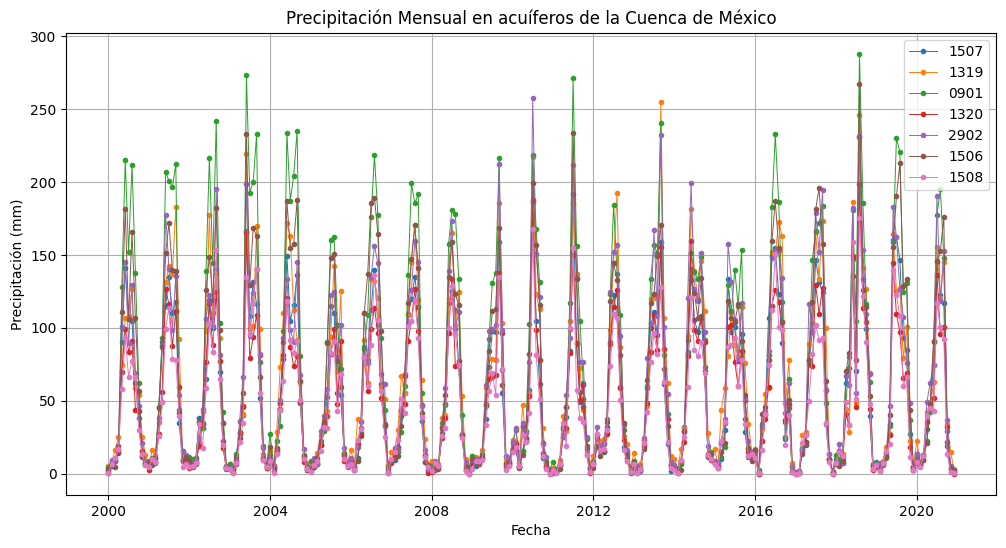

In [19]:
# Visualizar series mensuales por polígono
plt.figure(figsize=(12, 6))
for clave in df.columns:
    plt.plot(df.index, df[clave], label=clave, linestyle='-', marker='o', markersize=3, linewidth=0.7)
plt.xlabel('Fecha')
plt.ylabel('Precipitación (mm)')
plt.title('Precipitación Mensual en acuíferos de la Cuenca de México')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

SUMA DE PRECIPITACION MENSUAL DENTRO DEL AREA TOTAL DE LA CUENCA DE MÉXICO

In [20]:
# Función para obtener la media espacial de precipitación mensual dentro del area total de la Cuenca de México
def calcular_media_espacial_por_imagen(monthlyCollection, geometry):
    def calcular_media(imagen):
        media = imagen.reduceRegion(reducer=ee.Reducer.mean(), geometry=geometry, scale=2500).get('precipitation')
        year = imagen.get('year')
        month = imagen.get('month')
        date = ee.Date.fromYMD(year, month, 1).format('YYYY-MM')
        return ee.Feature(None, {'media': media, 'date': date})

    esp_med = monthlyCollection.map(calcular_media)
    # Extraer datos en listas
    fechas = esp_med.aggregate_array('date').getInfo()
    medias_valores = esp_med.aggregate_array('media').getInfo()

    # Crear un DataFrame y asignar los nombres de las columnas
    df = pd.DataFrame({
        'Fecha': pd.to_datetime(fechas, format='%Y-%m'),
        'Prec': medias_valores
    })

    return df

In [21]:
# Generar un dataframe
geometry = Capa_CM
serie_mensual_CM = calcular_media_espacial_por_imagen(PREC_MonthlyCollection, geometry)
serie_mensual_CM.set_index('Fecha', inplace=True)
serie_mensual_CM.head(2)

,Prec
Fecha,
2000-01-01,2.324267
2000-02-01,7.178985


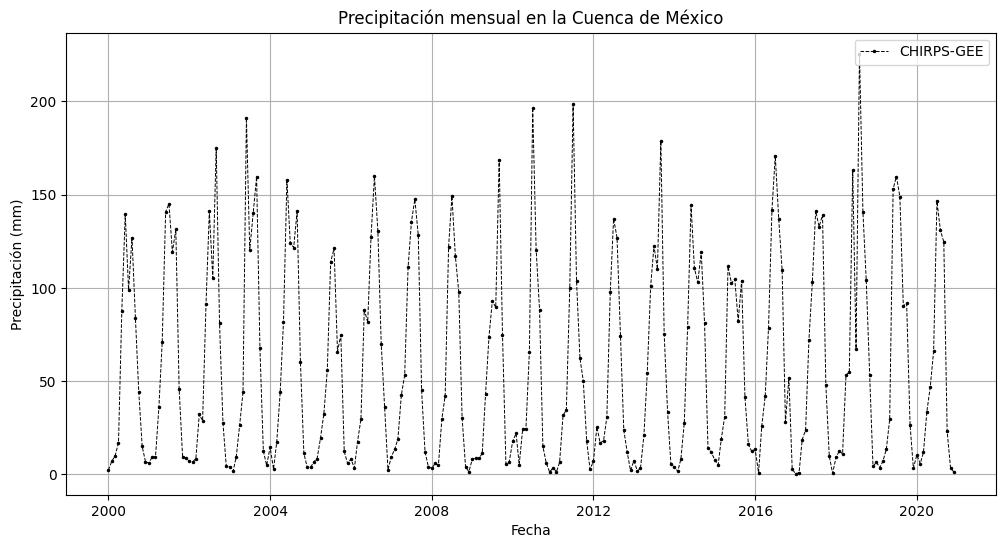

In [22]:
plt.figure(figsize=(12, 6))

plt.plot(serie_mensual_CM.index, serie_mensual_CM.values, color='#000000', label='CHIRPS-GEE', linestyle='--', marker='o', markersize=1.5, linewidth=0.7)
plt.xlabel('Fecha')
plt.ylabel('Precipitación (mm)')
plt.title('Precipitación mensual en la Cuenca de México')
plt.legend(loc='upper right')
plt.grid(True)

# Mostrar la gráfica
plt.show()

In [ ]:
outhpath = "/gdrive/My Drive/GitHub/RemoteSensing_DataAnalysis"

# Exportar las series mensuales
serie_mensual_CM.to_csv(os.path.join(outhpath, "series_prec_CM.csv"), index_label='Fecha')
df.to_csv(os.path.join(outhpath, "series_prec_poligonos.csv"), index_label='Fecha')